In [1]:
import pandas as pd
import numpy as np
from sklearn import utils
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv');
labels = np.array(df.iloc[:,0], dtype=np.int32)
samples = np.array(df.iloc[:,1:], dtype=np.float32) / 255.0 - 0.5
samples = samples.reshape(samples.shape[0], 28, 28, 1)
print(labels.shape)
print(samples.shape)

(42000,)
(42000, 28, 28, 1)


In [3]:
from collections import Counter
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(samples, labels, train_size=0.6, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.65, random_state=42)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

((25200, 28, 28, 1), (25200,))
((5880, 28, 28, 1), (5880,))
((10920, 28, 28, 1), (10920,))


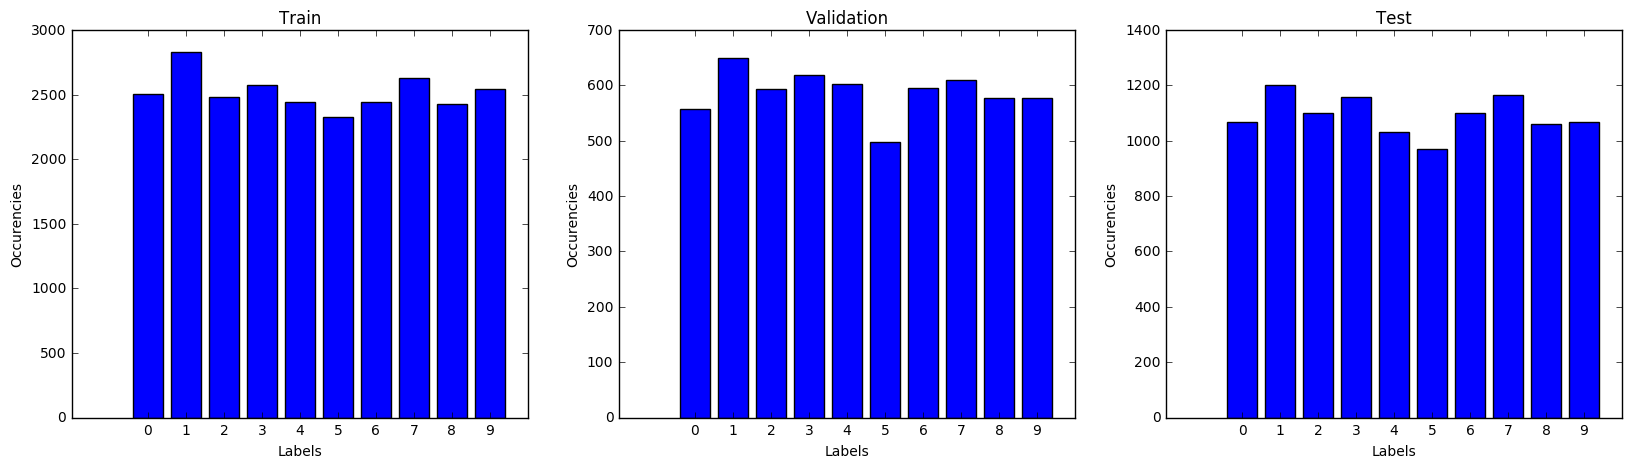

In [4]:
train_count = Counter(y_train)
test_count = Counter(y_test)
valid_count = Counter(y_valid)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(train_count.keys(), train_count.values(), align='center')
ax1.set_xticks(train_count.keys())
ax1.set_title('Train')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Occurencies')

ax2.bar(valid_count.keys(), valid_count.values(), align='center')
ax2.set_xticks(valid_count.keys())
ax2.set_title('Validation')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Occurencies')

ax3.bar(test_count.keys(), test_count.values(), align='center')
ax3.set_xticks(test_count.keys())
ax3.set_title('Test')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Occurencies')

In [5]:
def db_type():
    return tf.float32

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

In [26]:
image_size = 28 # 28*28
num_labels = 10 # 0-9
num_channels = 1 # grayscale
train_size = y_train.shape[0]

batch_size = 64
patch_size = 5
depth1 = 32
depth2 = 64
depth3 = 128
num_hidden1 = 512
num_hidden2 = 64
num_hidden3 = 32

In [27]:
tf_train_dataset = tf.placeholder(db_type(), shape=(batch_size, image_size, image_size, num_channels))
tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size,))
tf_valid_dataset = tf.constant(X_valid, dtype=db_type())
tf_test_dataset = tf.constant(X_test, dtype=db_type())

# Variables.
layer1_weight = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1, dtype=db_type()))
layer1_biases = tf.Variable(tf.zeros([depth1], dtype=db_type()))

layer2_weight = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1, dtype=db_type()))
layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2], dtype=db_type()))

layer3_weight = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev=0.1, dtype=db_type()))
layer3_biases = tf.Variable(tf.constant(0.1, shape=[depth3], dtype=db_type()))

fc1_weight = tf.Variable(tf.truncated_normal([12544/2, num_hidden1], stddev=0.1, dtype=db_type()))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden1], dtype=db_type()))

fc2_weight = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1, dtype=db_type()))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden2], dtype=db_type()))

fc3_weight = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1, dtype=db_type()))
fc3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=db_type()))

# Model.
def model(data, keep_prob):
    conv = tf.nn.conv2d(data, layer1_weight, strides=[1,1,1,1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, layer1_biases))
    pool = tf.nn.max_pool(relu, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    conv = tf.nn.conv2d(pool, layer2_weight, strides=[1,1,1,1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, layer2_biases))
    pool = tf.nn.max_pool(relu, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
    conv = tf.nn.conv2d(pool, layer3_weight, strides=[1,1,1,1], padding='SAME')        
    hidden = tf.nn.relu(tf.nn.bias_add(conv, layer3_biases))
    hidden = tf.nn.dropout(hidden, keep_prob)
        
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

    fc1 = tf.nn.bias_add(tf.matmul(reshape, fc1_weight), fc1_biases)
    fc2 = tf.nn.relu(tf.nn.bias_add(tf.matmul(fc1, fc2_weight), fc2_biases))
    
    return tf.nn.bias_add(tf.matmul(fc2, fc3_weight), fc3_biases)

logits = model(tf_train_dataset, 1.0) 
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
regularizers = (tf.nn.l2_loss(fc1_weight) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weight) + tf.nn.l2_loss(fc2_biases))
loss += 5e-4 * regularizers

batch = tf.Variable(0, dtype=db_type())    
learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)

train_pred = tf.nn.softmax(logits)
valid_pred = tf.nn.softmax(model(tf_valid_dataset, 1.0))
test_pred  = tf.nn.softmax(model(tf_test_dataset, 1.0))

In [28]:
num_steps = 1001

with tf.Session() as session:
    tf.initialize_all_variables().run()  
    print('Initialized')
    
    for step in xrange(int(10 * train_size) // batch_size):
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_pred], feed_dict=feed_dict)
            
        if (step % 100 == 0):
            train_accuracy = accuracy(predictions, batch_labels)
            valid_accuracy = accuracy(valid_pred.eval(), y_valid)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)    
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            
    
    print('Test accuracy: %.1f%%' % accuracy(test_pred.eval(), y_test))

Initialized
Minibatch loss at step 0: 14.264122
Minibatch accuracy: 3.1%
Validation accuracy: 10.4%
Minibatch loss at step 100: 6.561941
Minibatch accuracy: 90.6%
Validation accuracy: 89.2%
Minibatch loss at step 200: 6.541373
Minibatch accuracy: 90.6%
Validation accuracy: 93.8%
Minibatch loss at step 300: 6.197917
Minibatch accuracy: 96.9%
Validation accuracy: 95.2%
Minibatch loss at step 400: 6.161006
Minibatch accuracy: 96.9%
Validation accuracy: 96.7%
Minibatch loss at step 500: 6.055020
Minibatch accuracy: 96.9%
Validation accuracy: 96.6%
Minibatch loss at step 600: 6.128601
Minibatch accuracy: 93.8%
Validation accuracy: 96.9%
Minibatch loss at step 700: 5.963578
Minibatch accuracy: 95.3%
Validation accuracy: 97.3%
Minibatch loss at step 800: 5.883051
Minibatch accuracy: 98.4%
Validation accuracy: 97.7%
Minibatch loss at step 900: 5.789974
Minibatch accuracy: 100.0%
Validation accuracy: 97.2%
Minibatch loss at step 1000: 5.733007
Minibatch accuracy: 100.0%
Validation accuracy: 97.